<a href="https://colab.research.google.com/github/dragonheat123/nll_tryout/blob/master/NLLexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Start by generating synthetic dataset with a heteroscedastic distribution


---

heteroscedasticity (also spelled heteroskedasticity) refers to the circumstance in which the variability of a variable is unequal across the range of values of a second variable that predicts it.

Text(0.5,1,'plot of y with features')

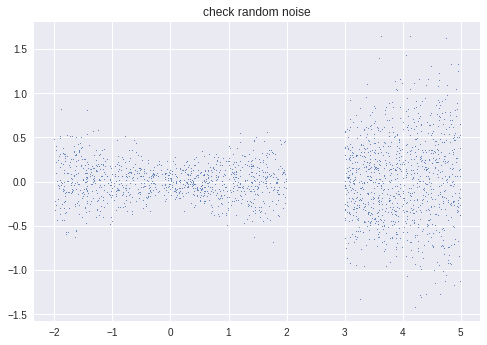

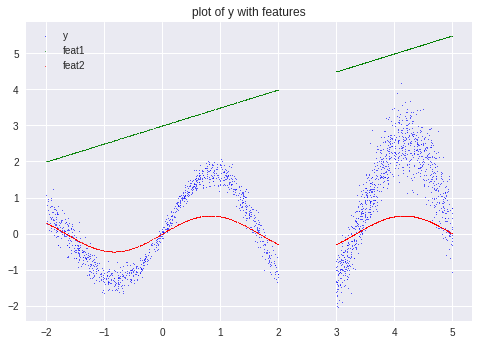

In [93]:
### here we sample x
x1 = np.random.randint(-200,200,1000)/100
x2 = np.random.randint(300,500,1000)/100
xrange = np.concatenate((x1,x2),axis=0)
np.shape(xrange)  ##xrange ranges from -2 to 5
noise_funct = np.random.normal(0,0.1*np.abs(xrange)+0.1) #more uncertainty at the edges

###generate random noise
plt.figure(1)
plt.scatter(xrange,noise_funct,s=0.5)
plt.title('check random noise')

### assume small noise in features
feat1 = 0.5*xrange+3 
feat2 = 0.5*np.sin(0.6*np.pi*xrange)
y = feat1*feat2 + noise_funct

plt.figure(2)
plt.scatter(xrange,y,s=0.3,c='b')
plt.scatter(xrange,feat1,s=0.3,c='g')
plt.scatter(xrange,feat2,s=0.3,c='r')
plt.legend(['y','feat1','feat2'])
plt.title('plot of y with features')


To find the optimal values for the parameters, we maximise the log likelihood function of the model.  
We assume that the output error is generated by a gaussian distribution:


---


$$log P(y|x,\theta) = log\Pi{P(y^i|x^i;\theta)}$$
$$= \sum logP(y^i|x^i;\theta)$$
$$=\sum log(\frac{1}{\sqrt{2\pi\sigma_{x^i}^2}} exp(-\frac{(y^i-f_\theta{x^i})^2}{2\sigma_{x^i}^2}))$$
$$= \sum log(1) - \frac{1}{2}log(2\pi) - \frac{1}{2}log(\sigma_{x^i}^2) - \frac{(y^i-f_\theta{x^i})^2}{2\sigma_{x^i}^2}$$


---


This is equivalant to minimizing the following function termed as negative log likelihood:
$$\sum -(-\frac{1}{2}log(\sigma_{x^i}^2) - \frac{(y^i-f_\theta{x^i})^2}{2\sigma_{x^i}^2}) = $$
$$\sum (\frac{1}{2}log(\sigma_{x^i}^2) + \frac{(y^i-f_\theta{x^i})^2}{2\sigma_{x^i}^2})$$


In [95]:
###def NLL and MSE loss and resulting model

import keras
from keras import backend as K
K.clear_session()

def nll_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)



Using TensorFlow backend.
